In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings

# Ignore the RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [46]:
# Load the data into DataFrames (assuming CSV format)
customers_df = pd.read_csv("CUSTOMERS.csv")
sellers_df = pd.read_csv("SELLERS.csv")
products_df = pd.read_csv("PRODUCTS.csv")
orders_df = pd.read_csv("ORDERS.csv")
order_items_df = pd.read_csv("ORDER_ITEMS.csv")
order_payments_df = pd.read_csv("ORDER_PAYMENTS.csv")
order_review_ratings_df = pd.read_csv("ORDER_REVIEW_RATINGS.csv")
geo_location_df = pd.read_csv("GEO_LOCATION.csv")

In [47]:
# Remove rows with "#N/A" in the 'product_category_name' column
products_df = products_df[products_df['product_category_name'] != '#N/A']


In [48]:
# Convert date columns to datetime objects
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'], format='%m/%d/%Y %H:%M')
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'], format='%m/%d/%Y %H:%M')
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'], format='%m/%d/%Y %H:%M')
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'], format='%m/%d/%Y %H:%M')
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'], format='%m/%d/%Y %H:%M')


In [49]:
# Convert date columns to datetime objects
order_review_ratings_df['review_creation_date'] = pd.to_datetime(order_review_ratings_df['review_creation_date'], format='%m/%d/%Y %H:%M')
order_review_ratings_df['review_answer_timestamp'] = pd.to_datetime(order_review_ratings_df['review_answer_timestamp'], format='%m/%d/%Y %H:%M')


In [50]:
# Display the head of each DataFrame
print("Customers DataFrame:")
print(customers_df.head())

print("\nSellers DataFrame:")
print(sellers_df.head())

print("\nProducts DataFrame:")
print(products_df.head())

print("\nOrders DataFrame:")
print(orders_df.head())

print("\nOrder Items DataFrame:")
print(order_items_df.head())

print("\nOrder Payments DataFrame:")
print(order_payments_df.head())

print("\nOrder Review Ratings DataFrame:")
print(order_review_ratings_df.head())

print("\nGeo Location DataFrame:")
print(geo_location_df.head())

Customers DataFrame:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix customer_city  customer_state  
0                     14409      Adilabad  Andhra Pradesh  
1                      9790         Adoni  Andhra Pradesh  
2                      1151  Akkarampalle  Andhra Pradesh  
3                      8775   Akkayapalle  Andhra Pradesh  
4                     13056         Alwal  Andhra Pradesh  

Sellers DataFrame:
                          seller_id  seller_zip_code_prefix   seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                   13023         Alwal   
1  d1b

In [63]:
# Calculate the metrics

# Total Revenue
total_revenue = order_payments_df['payment_value'].sum()

# Total Quantity
total_quantity = order_items_df['order_item_id'].sum()

# Total Products
total_products = products_df['product_id'].nunique()

# Total Categories
total_categories = products_df['product_category_name'].nunique()

# Total Sellers
total_sellers = sellers_df['seller_id'].nunique()

# Total Locations
total_locations = geo_location_df['geolocation_state'].nunique()

# Total Payment Methods
total_payment_methods = order_payments_df['payment_type'].nunique()

# Display the calculated metrics
print("Total Revenue:", total_revenue)
print("Total Quantity:", total_quantity)
print("Total Products:", total_products)
print("Total Categories:", total_categories)
print("Total Sellers:", total_sellers)
print("Total Locations:", total_locations)
print("Total Payment Methods:", total_payment_methods)

Total Revenue: 16008872.12
Total Quantity: 134936
Total Products: 32951
Total Categories: 71
Total Sellers: 3095
Total Locations: 20
Total Payment Methods: 5


In [64]:
#b Understanding how many new customers acquired every month

# Parse order purchase timestamp into datetime format
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])

# Extract month and year from purchase timestamp
orders_df['order_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')

# Group orders by month and count unique customers for each month
monthly_new_customers = orders_df.groupby('order_month')['customer_id'].nunique()

# Display the number of new customers for each month
print(monthly_new_customers)

order_month
2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
Freq: M, Name: customer_id, dtype: int64


In [65]:
#c Understand the retention of customers on month on month basis

# Parse order purchase timestamp into datetime format
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])

# Extract month and year from purchase timestamp
orders_df['order_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')

# Create a DataFrame with unique customers for each month
monthly_customers = orders_df.groupby('order_month')['customer_id'].nunique().reset_index()

# Initialize lists to store retention rate and previous month's customers
retention_rate = []
previous_month_customers = None

# Calculate retention rate for each month
for index, row in monthly_customers.iterrows():
    current_month_customers = row['customer_id']
    
    # For the first month, retention rate is 100%
    if index == 0:
        retention = 1.0
    else:
        # Calculate retention rate as the ratio of current month's customers to previous month's customers
        retention = current_month_customers / previous_month_customers
    
    # Append the retention rate to the list
    retention_rate.append(retention)
    
    # Update the previous month's customers for the next iteration
    previous_month_customers = current_month_customers

# Add the retention rate column to the monthly_customers DataFrame
monthly_customers['retention_rate'] = retention_rate

# Display the monthly retention rates
print(monthly_customers)

   order_month  customer_id  retention_rate
0      2016-09            4        1.000000
1      2016-10          324       81.000000
2      2016-12            1        0.003086
3      2017-01          800      800.000000
4      2017-02         1780        2.225000
5      2017-03         2682        1.506742
6      2017-04         2404        0.896346
7      2017-05         3700        1.539101
8      2017-06         3245        0.877027
9      2017-07         4026        1.240678
10     2017-08         4331        1.075758
11     2017-09         4285        0.989379
12     2017-10         4631        1.080747
13     2017-11         7544        1.629022
14     2017-12         5673        0.751988
15     2018-01         7269        1.281333
16     2018-02         6728        0.925574
17     2018-03         7211        1.071790
18     2018-04         6939        0.962280
19     2018-05         6873        0.990489
20     2018-06         6167        0.897279
21     2018-07         6292     

In [66]:
#d How the revenues from existing/new customers on month on month basis
# Parse order purchase timestamp into datetime format
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])

# Extract month and year from purchase timestamp
orders_df['order_month'] = orders_df['order_purchase_timestamp'].dt.to_period('M')

# Merge orders and order_items DataFrames to get revenue information
merged_df = pd.merge(orders_df, order_items_df, on='order_id', how='inner')

# Group merged DataFrame by month and calculate total revenue for each month
monthly_revenue = merged_df.groupby('order_month')['price'].sum().reset_index()

# Initialize lists to store revenue from existing and new customers
revenue_existing_customers = []
revenue_new_customers = []

# Calculate revenue from existing and new customers for each month
for index, row in monthly_revenue.iterrows():
    current_month = row['order_month']
    
    # Calculate revenue from existing customers in the current month
    existing_customers = orders_df[orders_df['order_month'] < current_month]['customer_id'].unique()
    revenue_existing = merged_df[(merged_df['order_month'] == current_month) & (merged_df['customer_id'].isin(existing_customers))]['price'].sum()
    revenue_existing_customers.append(revenue_existing)
    
    # Calculate revenue from new customers in the current month
    new_customers = orders_df[orders_df['order_month'] == current_month]['customer_id'].unique()
    revenue_new = merged_df[(merged_df['order_month'] == current_month) & (merged_df['customer_id'].isin(new_customers))]['price'].sum()
    revenue_new_customers.append(revenue_new)

# Add revenue columns to the monthly_revenue DataFrame
monthly_revenue['revenue_existing_customers'] = revenue_existing_customers
monthly_revenue['revenue_new_customers'] = revenue_new_customers

# Display the monthly revenue breakdown
print(monthly_revenue)

   order_month       price  revenue_existing_customers  revenue_new_customers
0      2016-09      267.36                         0.0                 267.36
1      2016-10    49507.66                         0.0               49507.66
2      2016-12       10.90                         0.0                  10.90
3      2017-01   120312.87                         0.0              120312.87
4      2017-02   247303.02                         0.0              247303.02
5      2017-03   374344.30                         0.0              374344.30
6      2017-04   359927.23                         0.0              359927.23
7      2017-05   506071.14                         0.0              506071.14
8      2017-06   433038.60                         0.0              433038.60
9      2017-07   498031.48                         0.0              498031.48
10     2017-08   573971.68                         0.0              573971.68
11     2017-09   624401.69                         0.0          

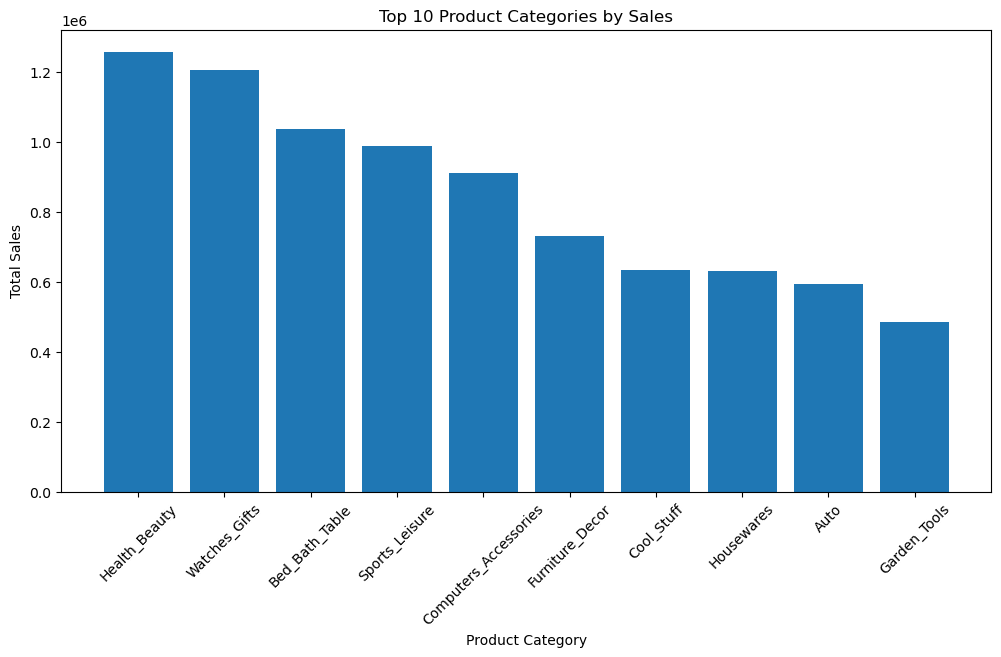

In [55]:
#e Understand the trends/seasonality of sales, quantity by category, location, month, week, day, time, channel, payment method

# Merge 'order_items_df' with 'products_df' to get product category information
order_item_product_df = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')

# Group by product category and calculate total sales and quantity
category_data = order_item_product_df.groupby('product_category_name').agg({'price': 'sum', 'order_item_id': 'sum'}).reset_index()

# Sort the data by total sales in descending order
category_data = category_data.sort_values(by='price', ascending=False)

# Plot top 10 product categories by sales
plt.figure(figsize=(12, 6))
plt.bar(category_data['product_category_name'][:10], category_data['price'][:10])
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.title('Top 10 Product Categories by Sales')
plt.xticks(rotation=45)
plt.show()


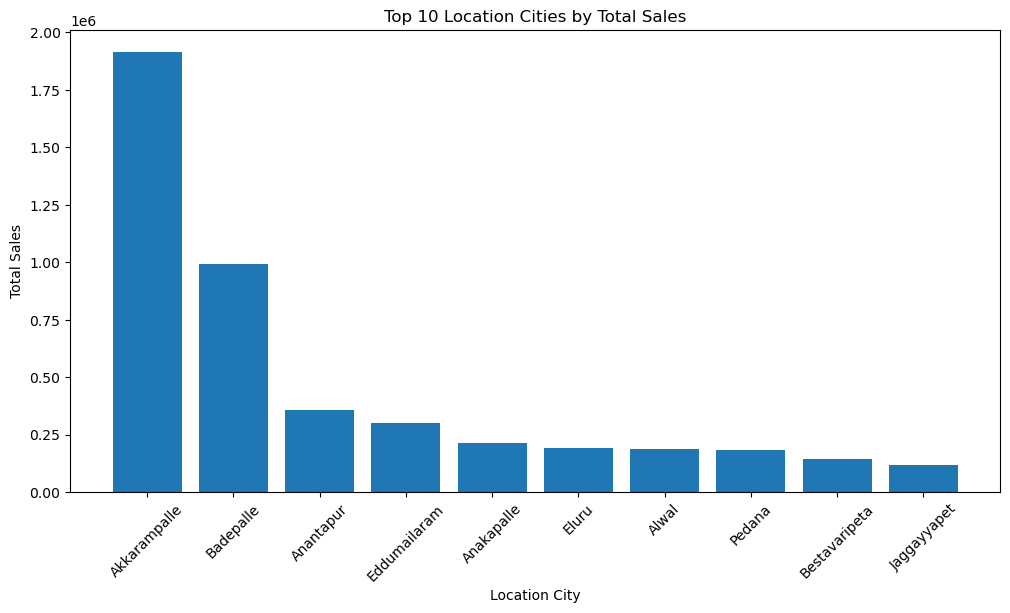

In [67]:
# Merge 'order_items_df' with 'products_df' to get product category information
order_item_product_df = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')

# Merge 'order_item_product_df' with 'order_df' to get order details
order_data = order_item_product_df.merge(orders_df[['order_id', 'customer_id', 'order_purchase_timestamp']], on='order_id', how='inner')

# Merge 'order_data' with 'customer_df' to get customer city
order_data = order_data.merge(customers_df[['customer_id', 'customer_city']], on='customer_id', how='inner')

# Group by customer city and calculate total sales
city_sales_data = order_data.groupby('customer_city')['price'].sum().reset_index()

# Sort the data by total sales in descending order
city_sales_data = city_sales_data.sort_values(by='price', ascending=False)

# Plot total sales vs location city
plt.figure(figsize=(12, 6))
plt.bar(city_sales_data['customer_city'][:10], city_sales_data['price'][:10])
plt.xlabel('Location City')
plt.ylabel('Total Sales')
plt.title('Top 10 Location Cities by Total Sales')
plt.xticks(rotation=45)
plt.show()



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10276\1368723145.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  order_data['order_week'] = order_data['order_purchase_timestamp'].dt.week


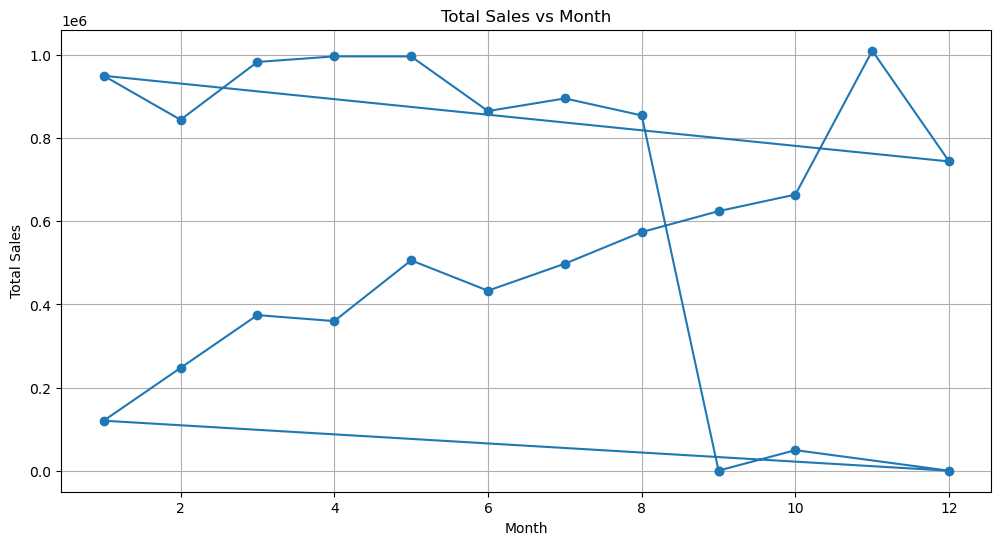

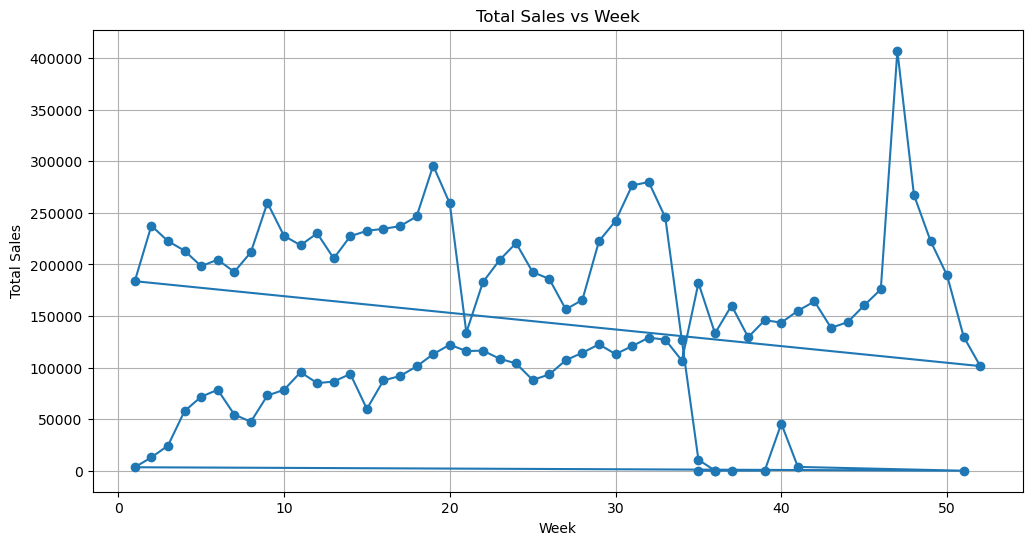

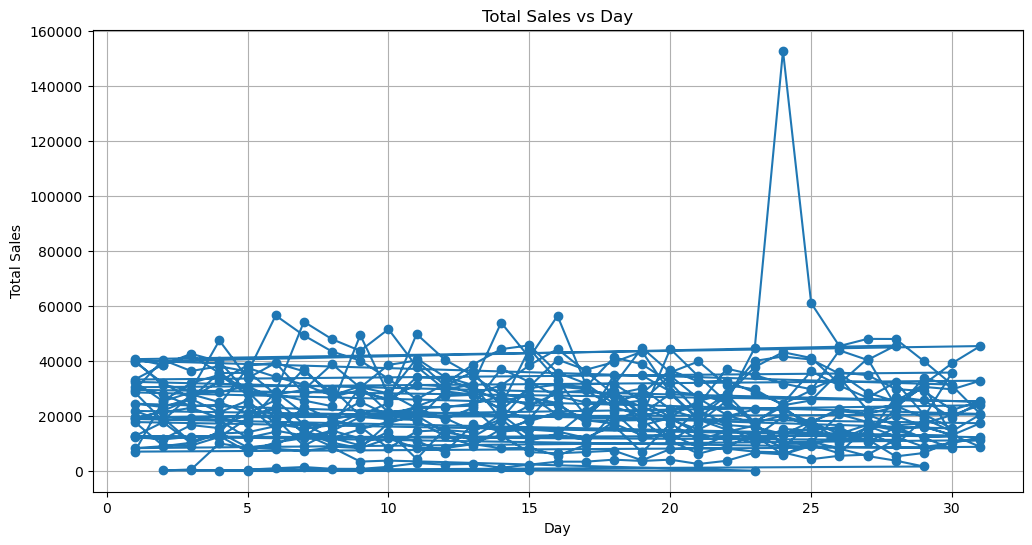

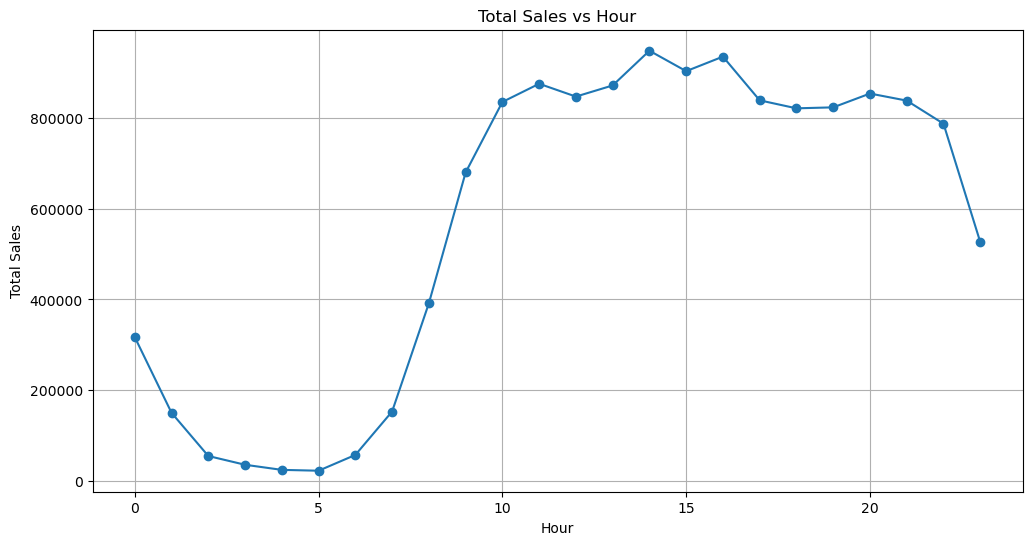

In [68]:


# Convert 'order_purchase_timestamp' column to datetime
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])

# Extract year, month, week, and day from the timestamp
order_data['order_year'] = order_data['order_purchase_timestamp'].dt.year
order_data['order_month'] = order_data['order_purchase_timestamp'].dt.month
order_data['order_week'] = order_data['order_purchase_timestamp'].dt.week
order_data['order_day'] = order_data['order_purchase_timestamp'].dt.day
order_data['order_hour'] = order_data['order_purchase_timestamp'].dt.hour

# Group by year and month to calculate total sales per month
monthly_sales_data = order_data.groupby(['order_year', 'order_month'])['price'].sum().reset_index()

# Group by week to calculate total sales per week
weekly_sales_data = order_data.groupby(['order_year', 'order_week'])['price'].sum().reset_index()

# Group by day to calculate total sales per day
daily_sales_data = order_data.groupby(['order_year', 'order_month', 'order_day'])['price'].sum().reset_index()

# Group by hour to calculate total sales per hour
hourly_sales_data = order_data.groupby(['order_hour'])['price'].sum().reset_index()

# Plot total sales vs month
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_data['order_month'], monthly_sales_data['price'], marker='o')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Month')
plt.grid(True)

# Plot total sales vs week
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales_data['order_week'], weekly_sales_data['price'], marker='o')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Week')
plt.grid(True)

# Plot total sales vs day
plt.figure(figsize=(12, 6))
plt.plot(daily_sales_data['order_day'], daily_sales_data['price'], marker='o')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Day')
plt.grid(True)

# Plot total sales vs hour
plt.figure(figsize=(12, 6))
plt.plot(hourly_sales_data['order_hour'], hourly_sales_data['price'], marker='o')
plt.xlabel('Hour')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Hour')
plt.grid(True)

plt.show()


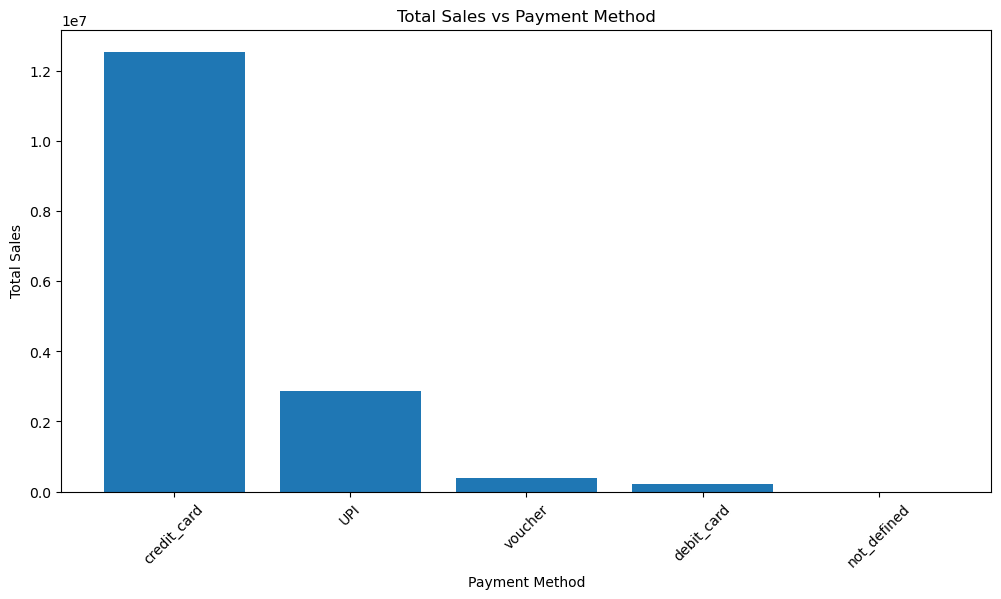

In [58]:

# Group by payment type and calculate total sales for each payment method
payment_sales_data = order_payments_df.groupby('payment_type')['payment_value'].sum().reset_index()

# Sort the data by total sales in descending order
payment_sales_data = payment_sales_data.sort_values(by='payment_value', ascending=False)

# Plot total sales vs payment method
plt.figure(figsize=(12, 6))
plt.bar(payment_sales_data['payment_type'], payment_sales_data['payment_value'])
plt.xlabel('Payment Method')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Payment Method')
plt.xticks(rotation=45)
plt.show()


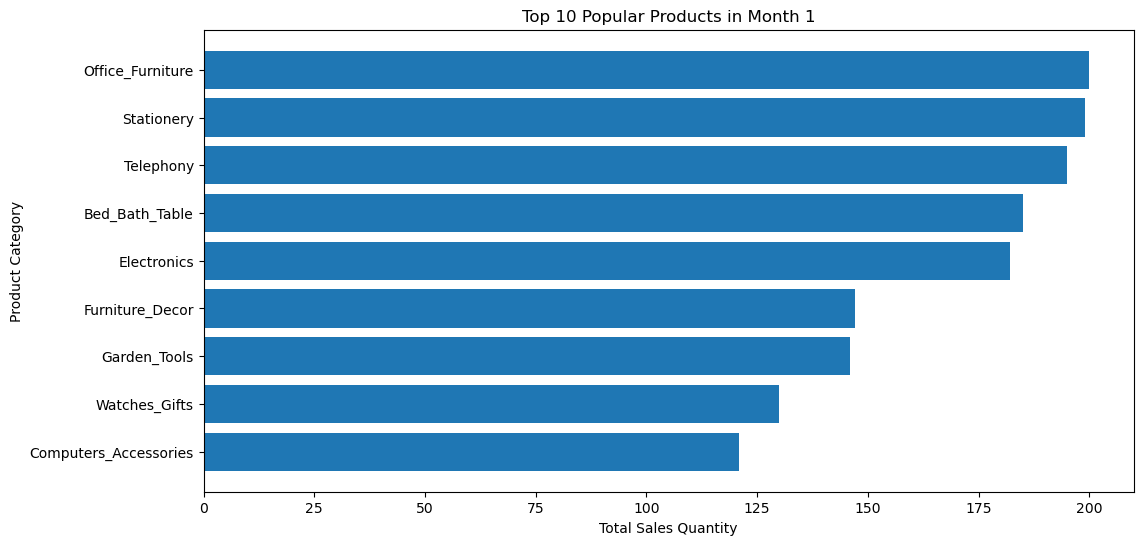

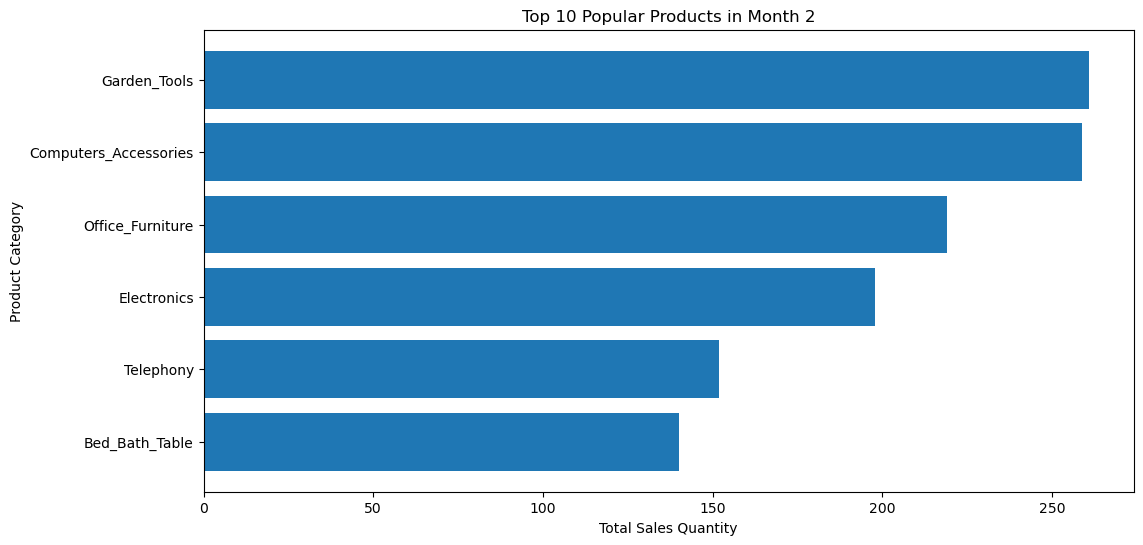

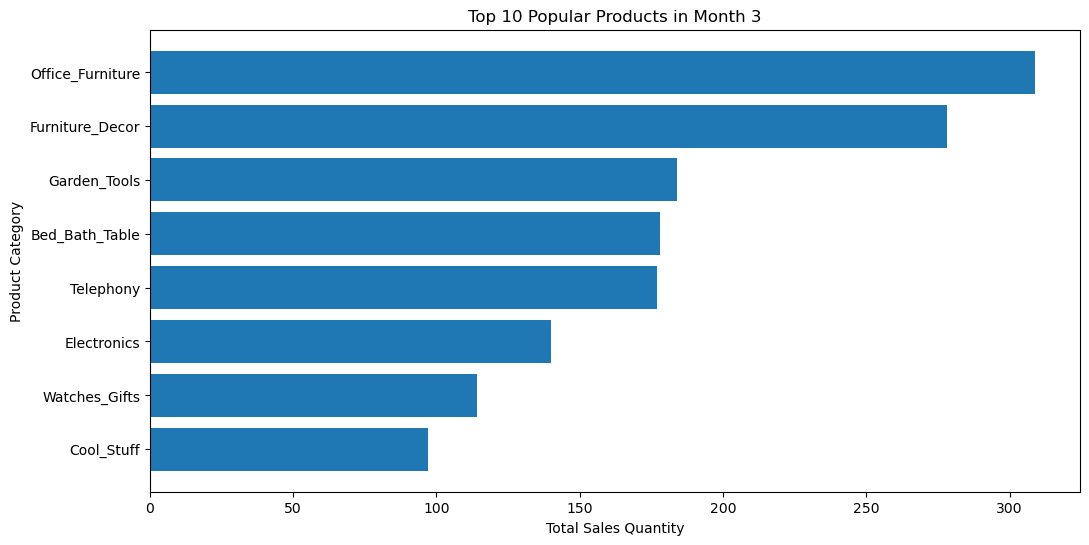

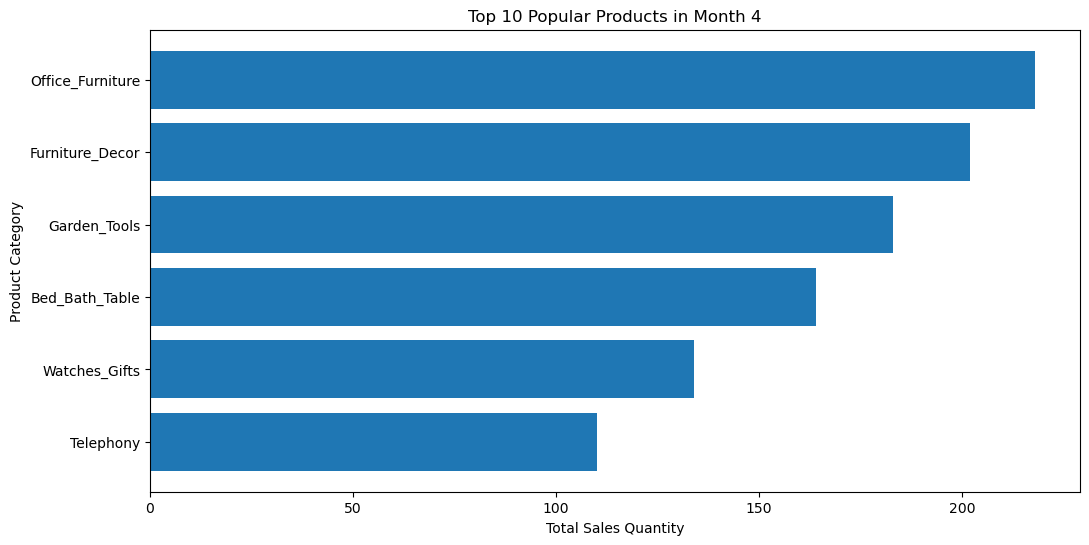

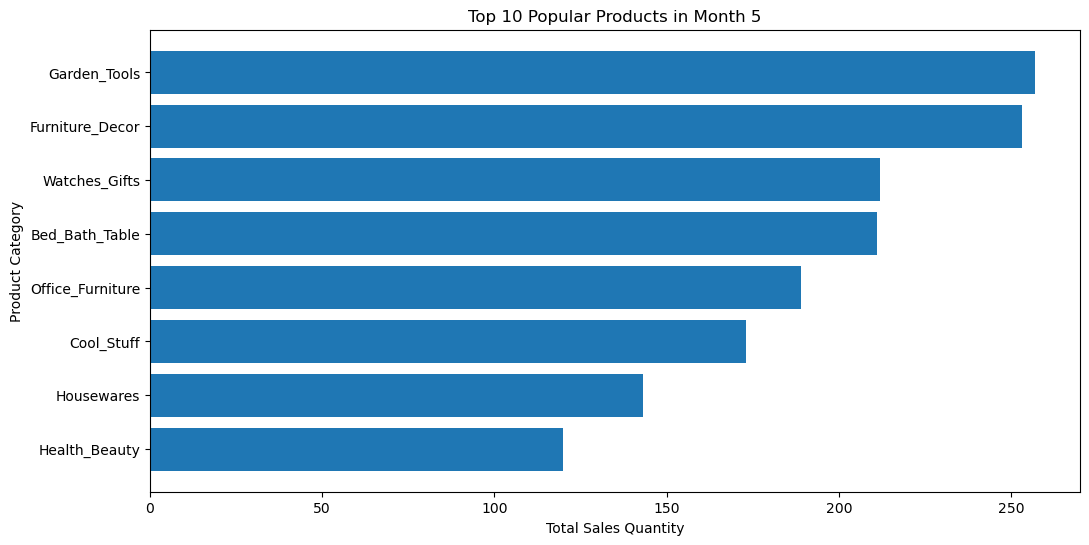

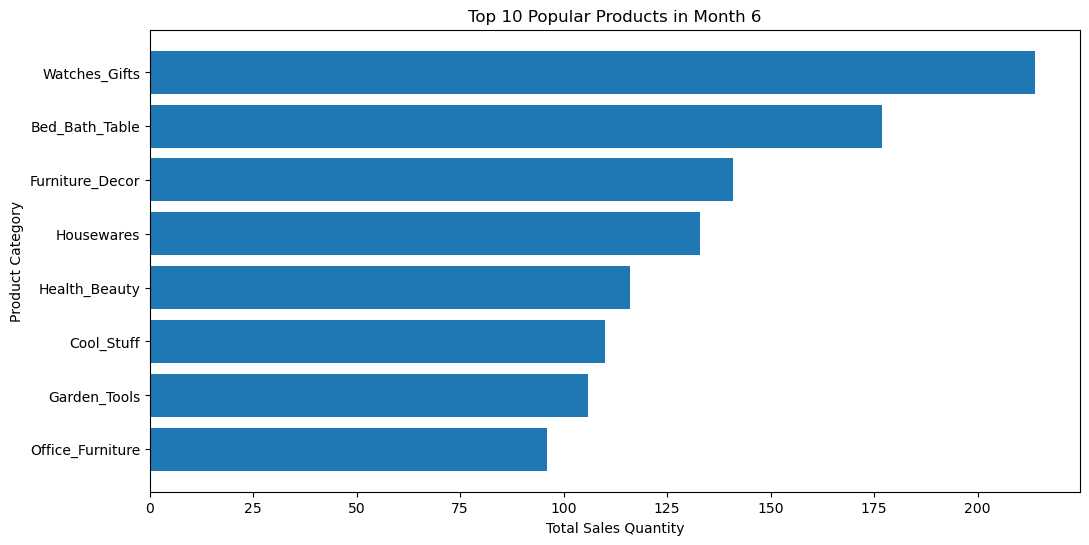

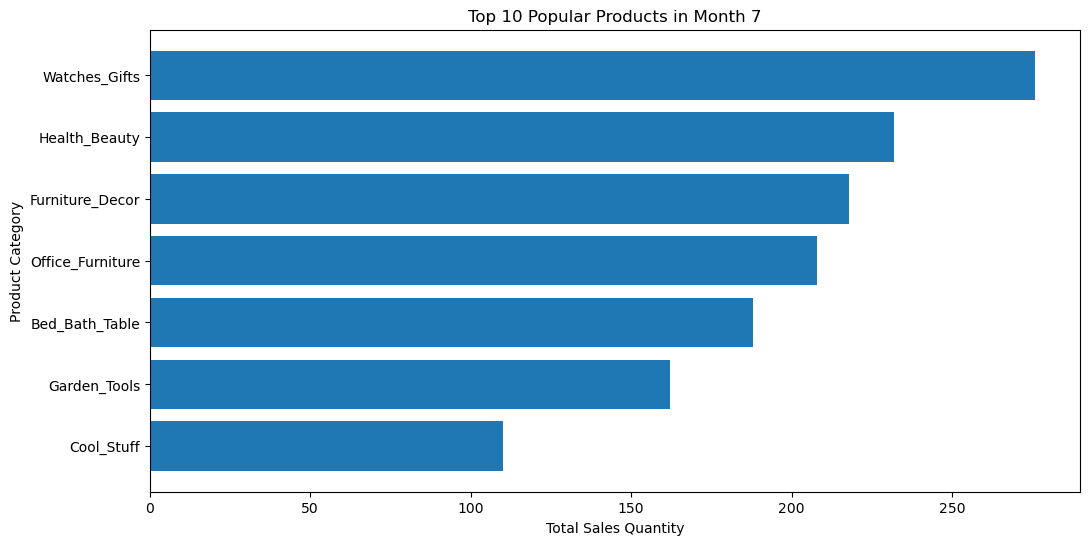

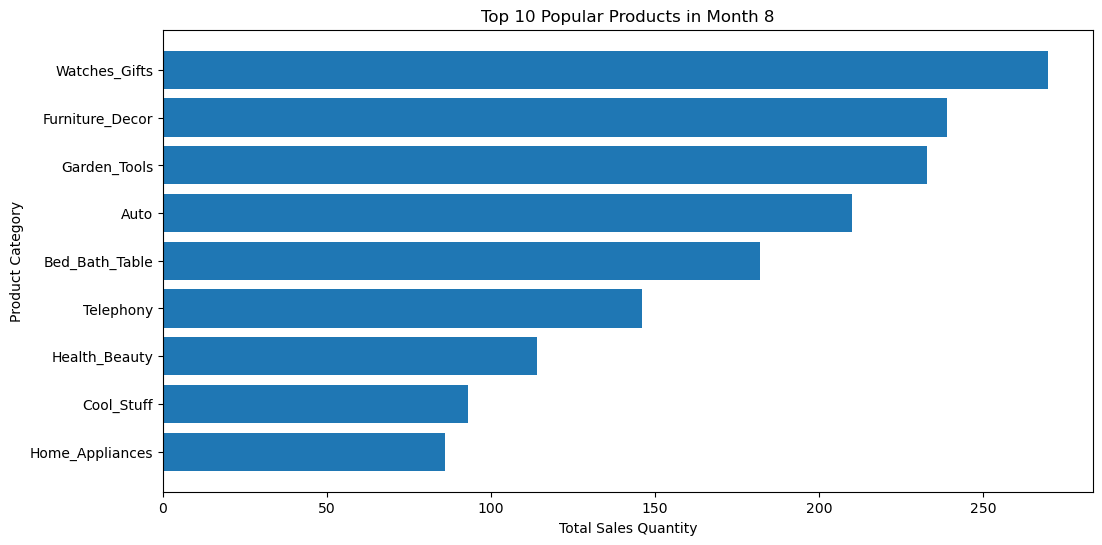

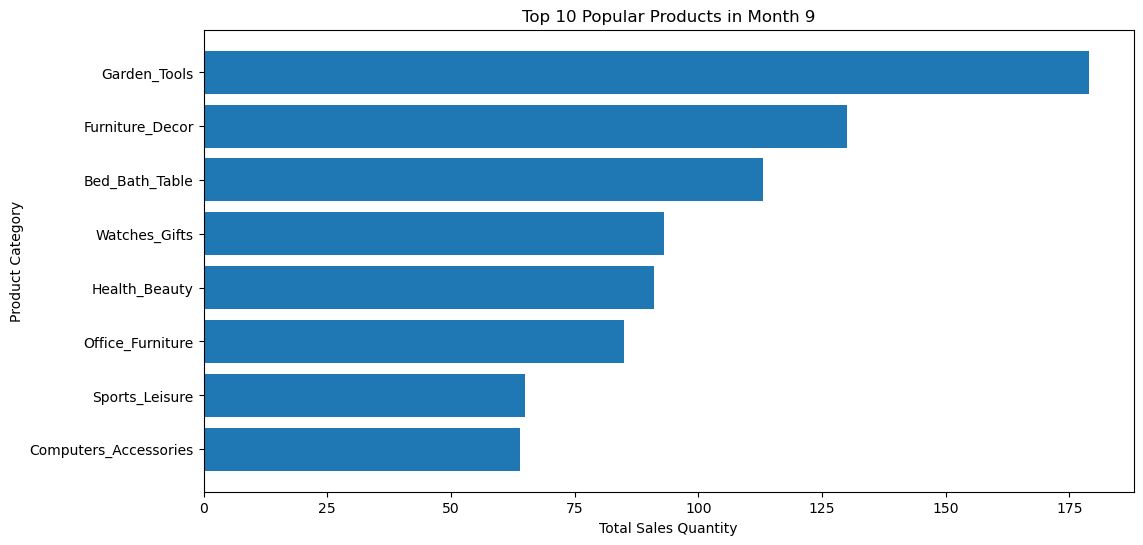

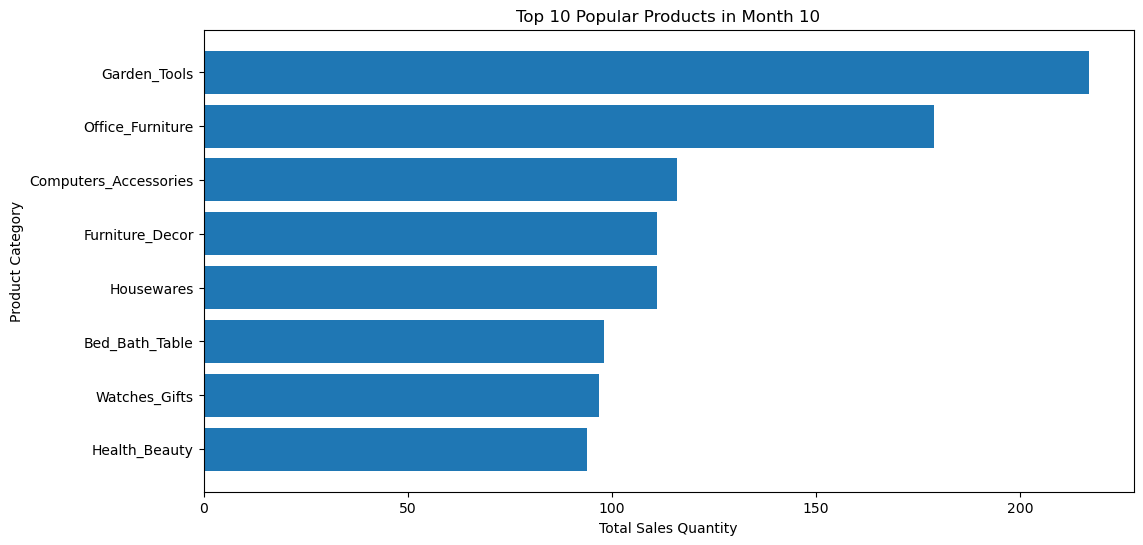

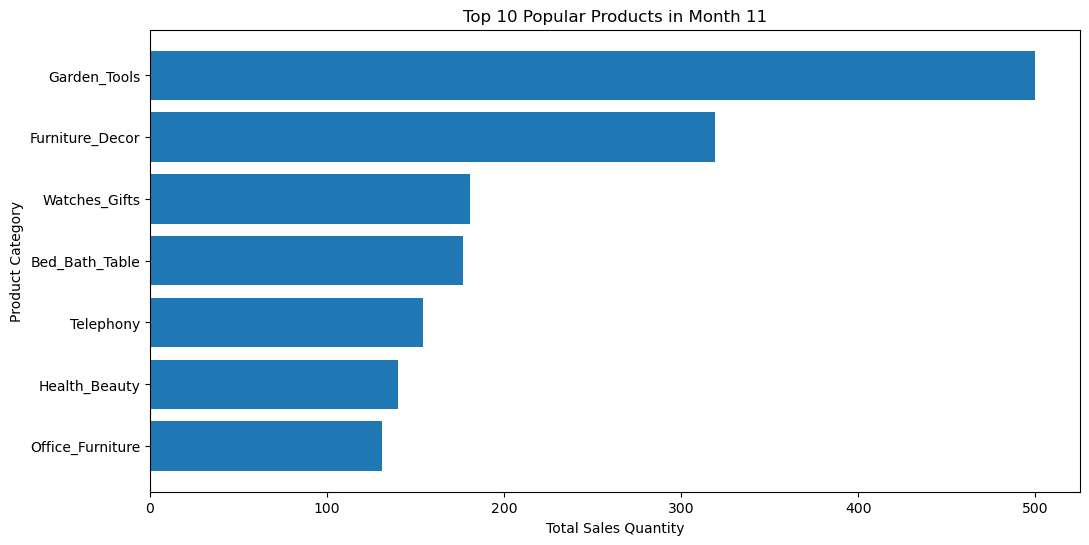

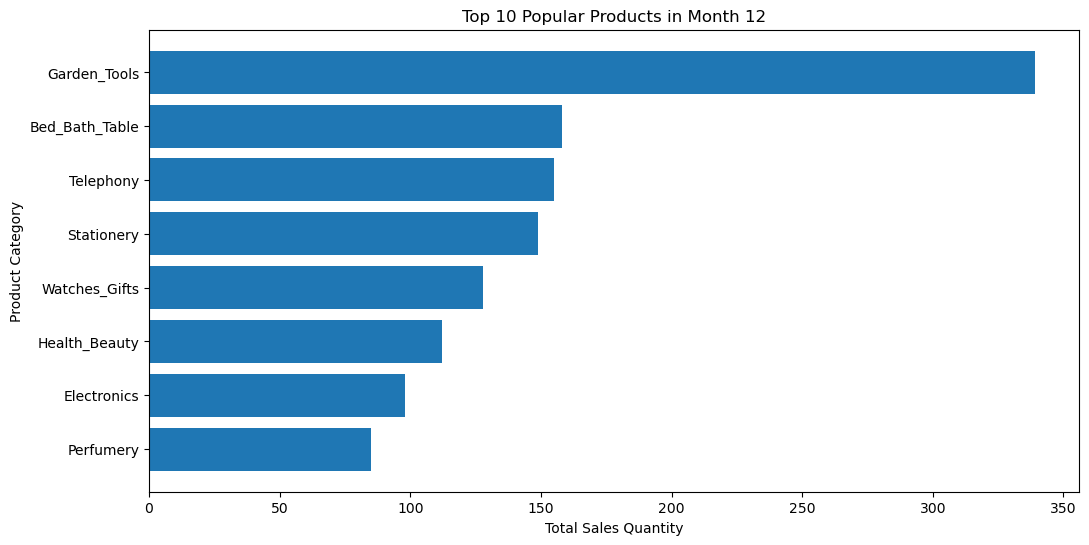

In [59]:

# Merge 'order_items_df' with 'products_df' to get product category information
order_item_product_df = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')

# Merge 'order_item_product_df' with 'order_df' to get order details
order_data = order_item_product_df.merge(orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='inner')

# Merge 'order_data' with 'sellers_df' to get seller information
order_data = order_data.merge(sellers_df[['seller_id', 'seller_state']], left_on='seller_id', right_on='seller_id', how='inner')

# Extract month from the 'order_purchase_timestamp'
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])
order_data['order_month'] = order_data['order_purchase_timestamp'].dt.month

# Group by month, seller, state, and category to calculate popularity metrics (e.g., total sales quantity)
popularity_data = order_data.groupby(['order_month', 'seller_id', 'seller_state', 'product_category_name'])['order_item_id'].sum().reset_index()

# Sort the data by popularity (e.g., total sales quantity)
popularity_data = popularity_data.sort_values(by='order_item_id', ascending=False)

# Plot the top popular products by month, seller, state, and category
# Example: Top 10 popular products by month
top_products_by_month = popularity_data.groupby('order_month').head(10)

# Plot the results
for month, group in top_products_by_month.groupby('order_month'):
    plt.figure(figsize=(12, 6))
    plt.barh(group['product_category_name'], group['order_item_id'])
    plt.xlabel('Total Sales Quantity')
    plt.ylabel('Product Category')
    plt.title(f'Top 10 Popular Products in Month {month}')
    plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
    plt.show()


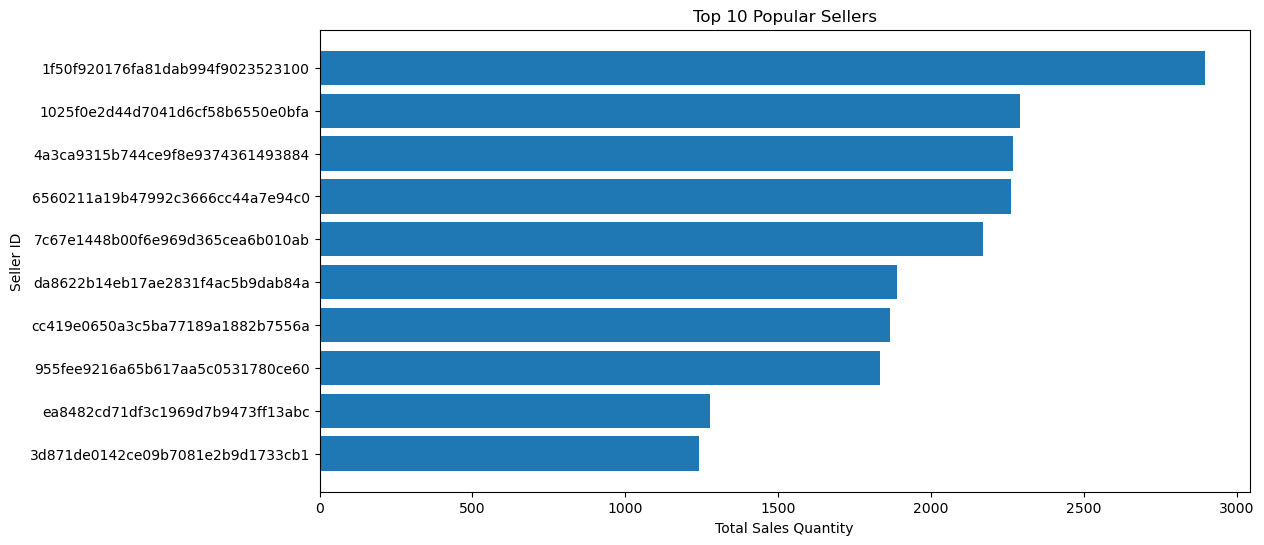

In [69]:

# Merge 'order_items_df' with 'products_df' to get product category information
order_item_product_df = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')

# Merge 'order_item_product_df' with 'order_df' to get order details
order_data = order_item_product_df.merge(orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='inner')

# Merge 'order_data' with 'sellers_df' to get seller information
order_data = order_data.merge(sellers_df[['seller_id', 'seller_state']], on='seller_id', how='inner')

# Extract month from the 'order_purchase_timestamp'
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])
order_data['order_month'] = order_data['order_purchase_timestamp'].dt.month

# Group by seller and calculate popularity metrics (e.g., total sales quantity)
popularity_data = order_data.groupby(['seller_id'])['order_item_id'].sum().reset_index()

# Sort the data by popularity (e.g., total sales quantity)
popularity_data = popularity_data.sort_values(by='order_item_id', ascending=False)

# Plot the top popular products by seller
plt.figure(figsize=(12, 6))
plt.barh(popularity_data['seller_id'][:10], popularity_data['order_item_id'][:10])
plt.xlabel('Total Sales Quantity')
plt.ylabel('Seller ID')
plt.title('Top 10 Popular Sellers')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()



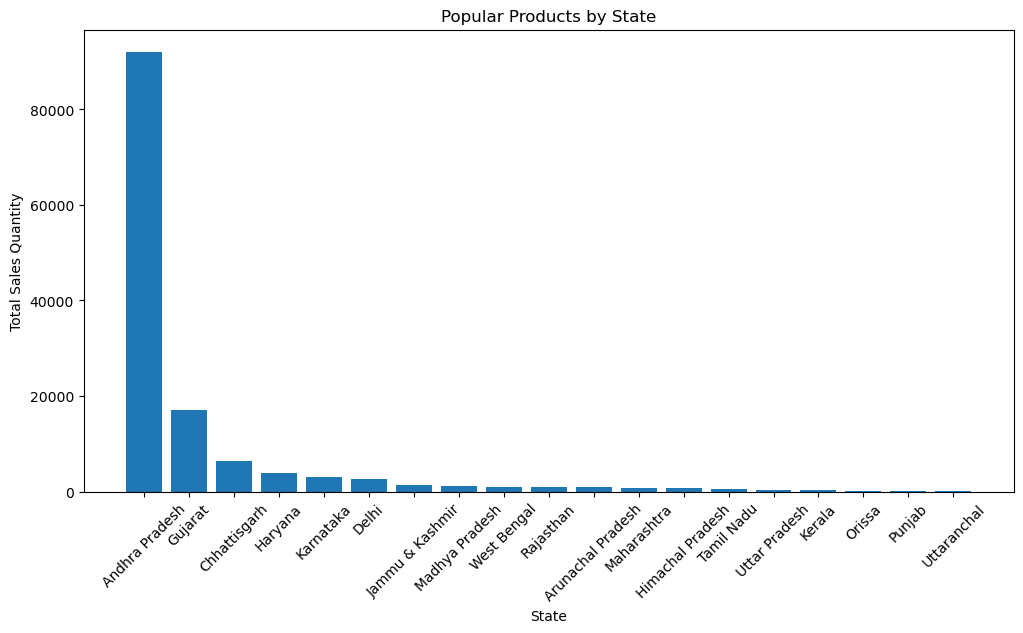

In [70]:

# Merge 'order_items_df' with 'products_df' to get product category information
order_item_product_df = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')

# Merge 'order_item_product_df' with 'order_df' to get order details
order_data = order_item_product_df.merge(orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='inner')

# Merge 'order_data' with 'sellers_df' to get seller information
order_data = order_data.merge(sellers_df[['seller_id', 'seller_state']], on='seller_id', how='inner')

# Extract month from the 'order_purchase_timestamp'
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])
order_data['order_month'] = order_data['order_purchase_timestamp'].dt.month

# Group by state and calculate popularity metrics (e.g., total sales quantity)
popularity_data = order_data.groupby(['seller_state'])['order_item_id'].sum().reset_index()

# Sort the data by popularity (e.g., total sales quantity)
popularity_data = popularity_data.sort_values(by='order_item_id', ascending=False)

# Plot the top popular products by state
plt.figure(figsize=(12, 6))
plt.bar(popularity_data['seller_state'], popularity_data['order_item_id'])
plt.xlabel('State')
plt.ylabel('Total Sales Quantity')
plt.title('Popular Products by State')
plt.xticks(rotation=45)
plt.show()


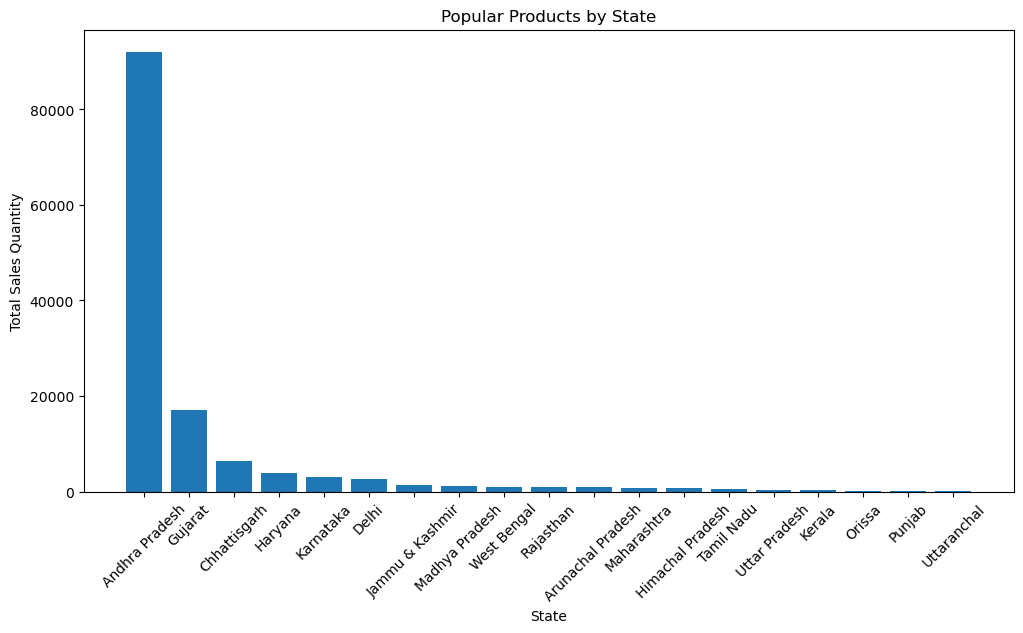

In [71]:
# Merge 'order_items_df' with 'products_df' to get product category information
order_item_product_df = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')

# Merge 'order_item_product_df' with 'order_df' to get order details
order_data = order_item_product_df.merge(orders_df[['order_id', 'order_purchase_timestamp']], on='order_id', how='inner')

# Merge 'order_data' with 'sellers_df' to get seller information
order_data = order_data.merge(sellers_df[['seller_id', 'seller_state']], on='seller_id', how='inner')

# Extract month from the 'order_purchase_timestamp'
order_data['order_purchase_timestamp'] = pd.to_datetime(order_data['order_purchase_timestamp'])
order_data['order_month'] = order_data['order_purchase_timestamp'].dt.month

# Group by state and calculate popularity metrics (e.g., total sales quantity)
popularity_data = order_data.groupby(['seller_state'])['order_item_id'].sum().reset_index()

# Sort the data by popularity (e.g., total sales quantity)
popularity_data = popularity_data.sort_values(by='order_item_id', ascending=False)

# Plot the top popular products by state
plt.figure(figsize=(12, 6))
plt.bar(popularity_data['seller_state'], popularity_data['order_item_id'])
plt.xlabel('State')
plt.ylabel('Total Sales Quantity')
plt.title('Popular Products by State')
plt.xticks(rotation=45)
plt.show()


In [76]:
# Assuming 'order_items_df' contains the 'price' and 'product_id' columns
# Merge 'order_items_df' with 'products_df' to get product category information
order_item_product_df = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')

# Group by product category and calculate total sales
category_sales_data = order_item_product_df.groupby('product_category_name')['price'].sum().reset_index()

# Sort the data by total sales in descending order
category_sales_data = category_sales_data.sort_values(by='price', ascending=False)

# Display the top product category name by total sales
top_product_category = category_sales_data.iloc[0]['product_category_name']
print("Top Product Category by Total Sales:", top_product_category)


Top Product Category by Total Sales: Health_Beauty


In [124]:
# Merge orders_df with order_items_df
merged_df = pd.merge(orders_df, order_items_df, on='order_id', how='inner')

# Merge the result with products_df
merged_df = pd.merge(merged_df, products_df, on='product_id', how='inner')

# Merge the result with sellers_df
merged_df = pd.merge(merged_df, sellers_df, on='seller_id', how='inner')



# Merge the result with customers_df using the customer_id column
merged_df = pd.merge(merged_df, customers_df, on='customer_id', how='inner')
# Merge customer_data with geolocation_df using the respective ZIP code prefix columns
merged_customer_geo_df = pd.merge(
    merged_df,
    geo_location_df,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner'
)

# Merge the result with order_payments_df using the order_id column
merged_df = pd.merge(merged_df, order_payments_df, on='order_id', how='inner')

# Merge the result with order_review_rating_df using the order_id column
merged_df = pd.merge(merged_df, order_review_ratings_df, on='order_id', how='inner')


In [125]:
# Calculate revenue by multiplying payment_value with payment_installments
merged_df['revenue'] = merged_df['payment_value'] * merged_df['payment_installments']

# Group customers by customer_id and aggregate revenue
customer_revenue = merged_df.groupby('customer_id')['revenue'].sum().reset_index()

# Now, you can divide customers into groups based on revenue, for example, quartiles
customer_revenue['revenue_group'] = pd.qcut(customer_revenue['revenue'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [126]:
# Display the first few rows of the customer_revenue DataFrame
print(customer_revenue.head())

# To see the distribution of customers in each revenue group
revenue_group_counts = customer_revenue['revenue_group'].value_counts()
print(revenue_group_counts)


                        customer_id  revenue revenue_group
0  00012a2ce6f8dcda20d059ce98491703   917.92            Q4
1  000161a058600d5901f007fab4c27140   337.05            Q3
2  0001fd6190edaaf884bcaf3d49edf079  1954.20            Q4
3  0002414f95344307404f0ace7a26f1d5   179.35            Q2
4  000379cdec625522490c315e70c7a9fb   107.01            Q2
Q1    24668
Q3    24667
Q2    24665
Q4    24665
Name: revenue_group, dtype: int64


In [127]:
# Merge sellers_df with order_items_df and store the result in merged_df
merged_df = pd.merge(merged_df, sellers_df, on='seller_id', how='inner')

# Calculate total revenue generated by each seller
seller_revenue = merged_df.groupby('seller_id')['price'].sum().reset_index()

# Define revenue groups based on revenue ranges
revenue_ranges = [0, 1000, 5000, 10000, 50000, float('inf')]
revenue_labels = ['Low', 'Low-Mid', 'Mid', 'High-Mid', 'High']

# Create a new column to indicate the revenue group for each seller
seller_revenue['revenue_group'] = pd.cut(seller_revenue['price'], bins=revenue_ranges, labels=revenue_labels)

# Display the first few rows of the seller_revenue DataFrame
print(seller_revenue.head())

# To see the distribution of sellers in each revenue group
revenue_group_counts = seller_revenue['revenue_group'].value_counts()
print(revenue_group_counts)


                          seller_id     price revenue_group
0  0015a82c2db000af6aaaf3ae2ecb0532   2685.00       Low-Mid
1  001cca7ae9ae17fb1caed9dfb1094831  25248.93      High-Mid
2  001e6ad469a905060d959994f1b41e4f    250.00           Low
3  002100f778ceb8431b7a1020ff7ab48f   1303.10       Low-Mid
4  003554e2dce176b5555353e4f3555ac8    120.00           Low
Low         1652
Low-Mid      858
Mid          276
High-Mid     269
High          40
Name: revenue_group, dtype: int64


In [129]:
# List the column names to check the actual names
print(merged_df.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_month', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix_x', 'seller_city_x', 'seller_state_x',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'revenue', 'review_id',
       'review_score', 'review_creation_date', 'review_answer_timestamp',
       'seller_zip_code_prefix_y', 'seller_city_y', 'seller_state_y'],
      dtype='object')


In [130]:
# Import necessary libraries
from itertools import combinations
from collections import Counter


# Create a list to store product combinations
product_combinations = []

# Iterate through each order and extract product combinations
for order_id, order_products in merged_df.iterrows():
    products_purchased = order_products[order_products == 1].index.tolist()
    
    # Generate all 2-item combinations from purchased products
    for combo in combinations(products_purchased, 2):
        product_combinations.append(tuple(sorted(combo)))

# Count the frequency of each product combination
combination_counts = Counter(product_combinations)

# Get the top 10 product combinations
top_10_combinations = combination_counts.most_common(10)

# Display the top 10 combinations
for i, (combo, count) in enumerate(top_10_combinations, 1):
    product1, product2 = combo
    print(f"Combination {i}: Products '{product1}' and '{product2}' sold together {count} times.")


Combination 1: Products 'order_item_id' and 'payment_sequential' sold together 99142 times.
Combination 2: Products 'payment_sequential' and 'product_photos_qty' sold together 56393 times.
Combination 3: Products 'payment_installments' and 'payment_sequential' sold together 54120 times.
Combination 4: Products 'order_item_id' and 'payment_installments' sold together 52327 times.
Combination 5: Products 'order_item_id' and 'product_photos_qty' sold together 50611 times.
Combination 6: Products 'payment_installments' and 'product_photos_qty' sold together 29207 times.
Combination 7: Products 'payment_sequential' and 'review_score' sold together 14765 times.
Combination 8: Products 'order_item_id' and 'review_score' sold together 11839 times.
Combination 9: Products 'product_photos_qty' and 'review_score' sold together 8192 times.
Combination 10: Products 'payment_installments' and 'review_score' sold together 7188 times.


Average payment value by customers: 172.58


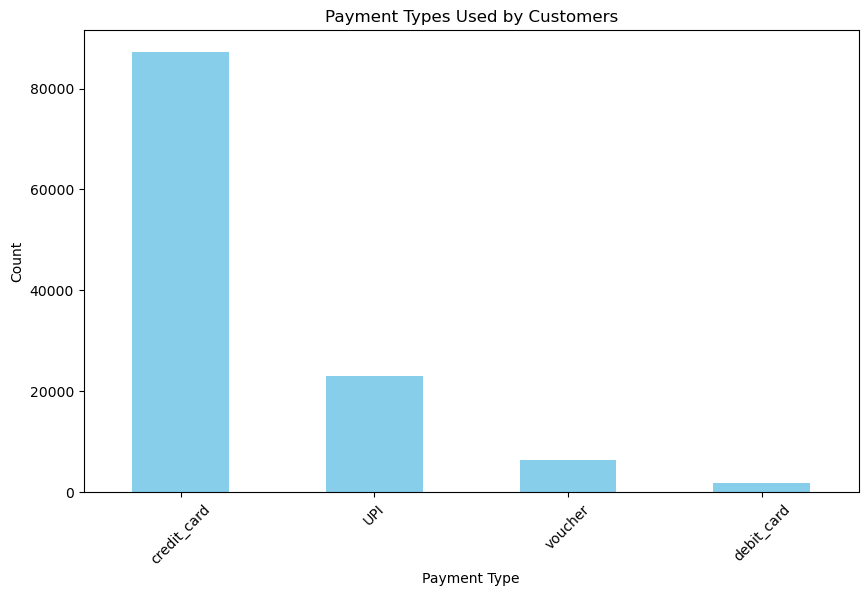

In [133]:
# Group by payment_type and count the occurrences
payment_counts = merged_df['payment_type'].value_counts()

# Calculate the average payment value
average_payment = merged_df['payment_value'].mean()

print(f"Average payment value by customers: {average_payment:.2f}")

# Plot payment types
plt.figure(figsize=(10, 6))
payment_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.title('Payment Types Used by Customers')
plt.xticks(rotation=45)
plt.show()


In [134]:
# Group by product category and calculate the average rating
category_ratings = merged_df.groupby('product_category_name')['review_score'].mean().reset_index()

# Sort by average rating in descending order to find the maximum rated categories
max_rated_categories = category_ratings.sort_values(by='review_score', ascending=False).head(10)

# Sort by average rating in ascending order to find the minimum rated categories
min_rated_categories = category_ratings.sort_values(by='review_score', ascending=True).head(10)

print("Top 10 Maximum Rated Categories:")
print(max_rated_categories)

print("\nTop 10 Minimum Rated Categories:")
print(min_rated_categories)


Top 10 Maximum Rated Categories:
                    product_category_name  review_score
11                      Cds_Dvds_Musicals      4.642857
29              Fashion_Childrens_Clothes      4.500000
8                  Books_General_Interest      4.431858
9                          Books_Imported      4.419355
10                        Books_Technical      4.345588
22                Costruction_Tools_Tools      4.333333
64  Small_Appliances_Home_Oven_And_Coffee      4.320513
37                             Food_Drink      4.312715
53                    Luggage_Accessories      4.290628
32                          Fashion_Sport      4.258065

Top 10 Minimum Rated Categories:
                product_category_name  review_score
61              Security_And_Services      2.500000
23                Diapers_And_Hygiene      3.256410
46                     Home_Comfort_2      3.387097
57                   Office_Furniture      3.516779
30              Fashion_Male_Clothing      3.531034
34   

In [135]:
# Group by product and calculate the average rating
product_ratings = merged_df.groupby('product_id')['review_score'].mean().reset_index()

# Sort by average rating in descending order to find the maximum rated products
max_rated_products = product_ratings.sort_values(by='review_score', ascending=False).head(10)

# Sort by average rating in ascending order to find the minimum rated products
min_rated_products = product_ratings.sort_values(by='review_score', ascending=True).head(10)

print("Top 10 Maximum Rated Products:")
print(max_rated_products)

print("\nTop 10 Minimum Rated Products:")
print(min_rated_products)


Top 10 Maximum Rated Products:
                             product_id  review_score
0      00066f42aeeb9f3007548bb9d3f33c38           5.0
17330  86743ff92eee3d16b7df59cddd583b8c           5.0
17345  868ceb027ab706a4dee42e2220006b85           5.0
17343  868969d3a93aeeab7bfcd4fc3d3d65de           5.0
17342  868766ed2172644fdd977d6bd395a107           5.0
17340  8684bd8f93b4f4038d07188a23811e93           5.0
17335  867c96d2bb67aba6500a4c509cf76072           5.0
17334  867b820367ec206b38a357f2c12454b7           5.0
17333  867901d7e8488fb97f1fb538c09d476e           5.0
17325  865bfa00c1dad8f4146d3c2765f051ca           5.0

Top 10 Minimum Rated Products:
                             product_id  review_score
11572  592cc6634d2c783d297effc0b828bc37           1.0
9385   482c25dc8512547962854dfff5ac057b           1.0
28997  e10c5041c0752194622a7a7016d8c9b5           1.0
9364   47fafa6908e75ae62b8a36a9eb3b9234           1.0
9346   47d85e3e35a3e29f93fdc12b295d520c           1.0
9344   47d6209a0b16

In [136]:
# Group by customer city and calculate the average rating
city_ratings = merged_df.groupby('customer_city')['review_score'].mean().reset_index()

print("Average Rating by Customer City:")
print(city_ratings)


Average Rating by Customer City:
       customer_city  review_score
0          Aadityana      3.968750
1       Aambaliyasan      3.500000
2          Aantaliya      3.870370
3         Aarambhada      3.596154
4           Abiramam      5.000000
...              ...           ...
4105  Zamin Uthukuli      4.000000
4106    Ziauddin Pur      4.037267
4107            Zira      4.600000
4108        Zirakpur      4.500000
4109            Ziro      3.964286

[4110 rows x 2 columns]


In [139]:
# Group by seller and calculate the average rating
seller_ratings = merged_df.groupby('seller_id')['review_score'].mean().reset_index()

print("Average Rating by Seller:")
print(seller_ratings)

Average Rating by Seller:
                             seller_id  review_score
0     0015a82c2db000af6aaaf3ae2ecb0532      3.666667
1     001cca7ae9ae17fb1caed9dfb1094831      3.883817
2     001e6ad469a905060d959994f1b41e4f      1.000000
3     002100f778ceb8431b7a1020ff7ab48f      4.033898
4     003554e2dce176b5555353e4f3555ac8      5.000000
...                                ...           ...
3090  ffcfefa19b08742c5d315f2791395ee5      1.000000
3091  ffdd9f82b9a447f6f8d4b91554cc7dd3      4.285714
3092  ffeee66ac5d5a62fe688b9d26f83f534      4.214286
3093  fffd5413c0700ac820c7069d66d98c89      3.838710
3094  ffff564a4f9085cd26170f4732393726      2.100000

[3095 rows x 2 columns]


In [140]:
# Group by product category and calculate average rating
average_category_ratings = merged_df.groupby('product_category_name')['review_score'].mean().reset_index()

# Sort by average rating in descending order
average_category_ratings = average_category_ratings.sort_values(by='review_score', ascending=False)
print("Average Rating by Product Category:")
print(average_category_ratings)

Average Rating by Product Category:
        product_category_name  review_score
11          Cds_Dvds_Musicals      4.642857
29  Fashion_Childrens_Clothes      4.500000
8      Books_General_Interest      4.431858
9              Books_Imported      4.419355
10            Books_Technical      4.345588
..                        ...           ...
30      Fashion_Male_Clothing      3.531034
57           Office_Furniture      3.516779
46             Home_Comfort_2      3.387097
23        Diapers_And_Hygiene      3.256410
61      Security_And_Services      2.500000

[71 rows x 2 columns]


In [143]:

# Extract year and month from 'order_purchase_timestamp'
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['order_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')

# Group by year and month, and calculate average rating
average_monthly_ratings = merged_df.groupby('order_month')['review_score'].mean().reset_index()

# Sort by year and month
average_monthly_ratings = average_monthly_ratings.sort_values(by='order_month')

print("Average Rating by Months:")
print(average_monthly_ratings)

Average Rating by Months:
   order_month  review_score
0      2016-09      1.000000
1      2016-10      3.585492
2      2016-12      5.000000
3      2017-01      4.087977
4      2017-02      4.041003
5      2017-03      4.049360
6      2017-04      3.959497
7      2017-05      4.117210
8      2017-06      4.117216
9      2017-07      4.108042
10     2017-08      4.202527
11     2017-09      4.125560
12     2017-10      4.040947
13     2017-11      3.825638
14     2017-12      3.927824
15     2018-01      3.926072
16     2018-02      3.723863
17     2018-03      3.681448
18     2018-04      4.063218
19     2018-05      4.119670
20     2018-06      4.177258
21     2018-07      4.209897
22     2018-08      4.205520
23     2018-09      1.000000
